# Read me
Project Group 10 - Tutorial WG 01

Amalia Stuger - 13207342

Maarten Hoogeboom - 14000369

Ragini Shukla - 16035267

Roel Lust - 13985736

In [ ]:
#basics
import random
import ast
import json
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import plotly.graph_objects as go


#Plotly
import plotly.express as px

#Lime & Shap
import lime
import lime.lime_tabular
import shap


#Sklearn
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
from PIL import Image
from io import BytesIO


from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb

#





# Business and Data understanding

In [32]:
df_calander = pd.read_csv("data/calendar_summary.csv", sep=";")
df_listings = pd.read_csv("data/listings.csv", sep=",")
df_listings_detailed = pd.read_excel("data/listings_detailed.xlsx")
df_neighbourhoods = pd.read_csv("data/neighbourhoods.csv", sep=",")
df_reviews = pd.read_csv("data/reviews.csv", sep=",")

def pct_to_fraction(series):
    """Convert strings like '100%' to 1.0 and keep NaN as NaN."""
    return (
        pd.to_numeric(
            series.astype(str).str.strip().str.rstrip('%'),
            errors='coerce'
        ) / 100
    )

def pricestring_to_numeric(series):
    """
    Convert strings like '$100' or '$100%' to numeric 100.
    Keeps NaN as NaN.
    """
    return pd.to_numeric(
        series.astype(str)
              .str.strip()       # remove leading/trailing spaces
              .str.lstrip('$')   # remove leading dollar sign
              .str.rstrip('%')  # remove trailing percent if any
              .str.replace(',', ''),   # <-- remove commas
        errors='coerce'
    )



def tf_to_bool(series):
    """Map 't' and 'f' (case-insensitive) to True/False; leave others/NaN as NaN."""
    return (
        series.astype(str).str.lower()
        .map({'t': 1.0, 'f': 0.0})
    )


df_listings_detailed['host_response_rate'] = pct_to_fraction(df_listings_detailed['host_response_rate'])
df_listings_detailed['host_acceptance_rate'] = pct_to_fraction(df_listings_detailed['host_acceptance_rate'])
df_listings_detailed['host_is_superhost'] = tf_to_bool(df_listings_detailed['host_is_superhost'])
df_listings_detailed['host_has_profile_pic'] = tf_to_bool(df_listings_detailed['host_has_profile_pic'])
df_listings_detailed['host_identity_verified'] = tf_to_bool(df_listings_detailed['host_identity_verified'])
df_listings_detailed['instant_bookable'] = tf_to_bool(df_listings_detailed['instant_bookable'])
df_listings_detailed['price'] = pricestring_to_numeric(df_listings_detailed['price'])



df_listings_detailed.drop(columns=['listing_url', 'scrape_id',"last_scraped",
                                   "neighborhood_overview","host_id",
                                   "host_url", "host_since","host_location",
                                   "host_about","host_picture_url",
                                   "neighbourhood","neighbourhood_group_cleansed","bathrooms_text"], inplace=True)

In [33]:
nan_percent = df_listings_detailed.isna().mean() * 100
nan_df = nan_percent.reset_index()
nan_df.columns = ["feature", "nan_percentage"]

nan_df.sort_values(by="nan_percentage", ascending=False, inplace=True)
nan_df.head(10)

,feature,nan_percentage
22,bathrooms,100.000000
35,calendar_updated,100.000000
54,license,71.736163
6,host_response_rate,68.751551
5,host_response_time,68.751551
7,host_acceptance_rate,67.913874
10,host_neighbourhood,35.449243
53,review_scores_value,14.327377
52,review_scores_location,14.327377
50,review_scores_checkin,14.327377


In [55]:
# Compute NaN %
nan_percent = df_listings_detailed.isna().mean() * 100
nan_df = nan_percent.reset_index()
nan_df.columns = ["feature", "nan_percentage"]



# Top 10
top10 = nan_df.sort_values("nan_percentage", ascending=False).head(10)

# X-axis ticks
tickvals = list(range(len(top10)))
ticktext = top10["feature"].tolist()

# Plotly bar chart
fig = px.bar(
    top10,
    x=tickvals,
    y="nan_percentage",
    text="nan_percentage",
)

# Improve spacing for labels above bars
fig.update_traces(
    texttemplate='%{text:.1f}%',
    textposition='outside'
)

# Expand y-range to give text room
max_y = top10["nan_percentage"].max()
fig.update_yaxes(range=[0, max_y * 1.25])  # expand 25%



# Final layout
fig.update_layout(
    margin=dict(t=30),
    barmode='stack',
    xaxis=dict(
        tickmode='array',
        title="Features present in the dataset",
        tickvals=tickvals,
        ticktext=ticktext,
        showgrid=False,
        zeroline=False,
        tickfont=dict(family='Arial', size=12, color='#2c3e50'),
    ),
    yaxis=dict(
        title='Missing (%)',
        gridcolor='#ecf0f1',
        zeroline=False,
        tickfont=dict(family='Arial', size=12, color='#2c3e50'),
    ),
    plot_bgcolor='white',
    width=1000,
    height=480,
    title=dict(
        text="Top 10 Features by Percentage of Missing Values",
        x=0.5,
        xanchor='center',
        font=dict(family='Arial', size=20, color='#2c3e50')
    )
)

fig.show()


``we will need to atleast remove bathrooms, and calendar_updated from our dataset``

In [34]:
df_listings_detailed["number_of_reviews"].value_counts()

number_of_reviews
0      2087
1      1347
2      1060
3       918
4       747
       ... 
370       1
138       1
804       1
177       1
215       1
Name: count, Length: 409, dtype: int64

``It seems that most listings have little to no reviews!``

In [56]:

min_reviews = 5

# Compute stats
num_remaining = (df_listings_detailed["number_of_reviews"] >= min_reviews).sum()
percent_remaining = num_remaining / len(df_listings_detailed) * 100

# Create figure
fig = go.Figure()

# Histogram
fig.add_trace(
    go.Histogram(
        x=df_listings_detailed["number_of_reviews"],
        nbinsx=150,
        marker=dict(color='skyblue', line=dict(color='black', width=1)),
        name="Distribution"
    )
)

# Vertical line
fig.add_shape(
    type="line",
    x0=min_reviews,
    x1=min_reviews,
    y0=0,
    y1=1,
    yref='paper',
    line=dict(color='red', width=2, dash='dash'),
)

fig.add_annotation(
    x=min_reviews,
    y=1,
    yref='paper',
    text=f"Min reviews = {min_reviews}",
    showarrow=False,
    yshift=-350,
    xshift=20,     # <-- add horizontal space
    font=dict(color='red')
)


# Layout
fig.update_layout(
    width=1000,
    height=480,
    margin=dict(t=60),
    title=(
        f"Distribution of Number of Reviews<br>"
        f"Keeping {num_remaining} listings ({percent_remaining:.1f}%) with ≥ {min_reviews} reviews"
    ),
    xaxis=dict(
        title="Number of Reviews",
        zeroline=False,
        showgrid=False,
        tickfont=dict(family='Arial', size=12, color='#2c3e50'),
    ),
    yaxis=dict(
        title="Count",
        range=[0, 3000],
        gridcolor='#ecf0f1',
        tickfont=dict(family='Arial', size=12, color='#2c3e50'),
    ),
    plot_bgcolor='white',
)

fig.show()


``we will need to filter our data so that each listing has at least 5 reviews``

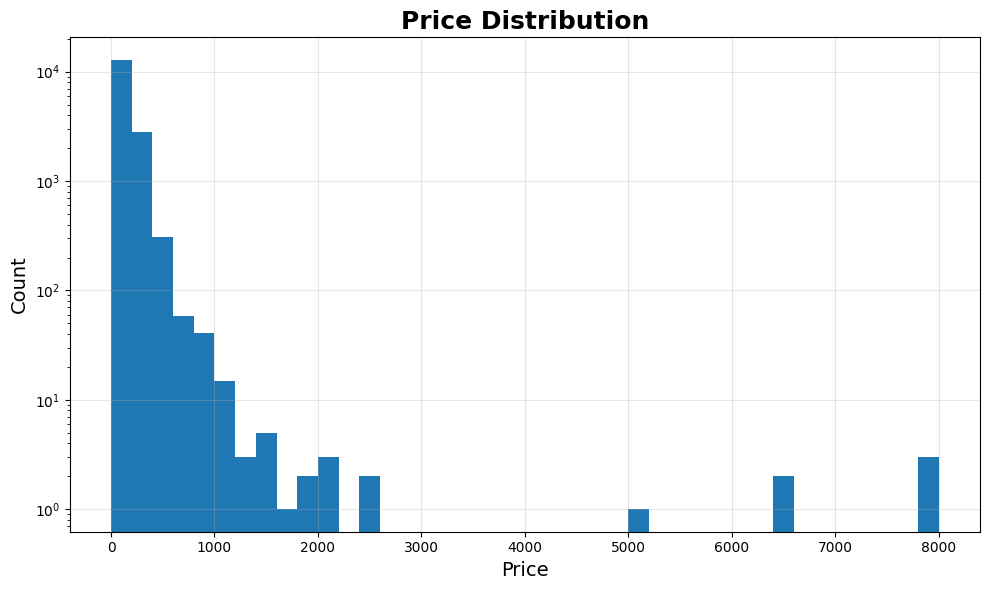

In [36]:
# Price distribution histogram
plt.figure(figsize=(10, 6))
 
plt.hist(df_listings_detailed['price'], bins=40)   # number of bins = smoother distribution
                                # color left as default (required)
 
plt.title("Price Distribution", fontsize=18, fontweight='bold')
plt.xlabel("Price", fontsize=14)
plt.ylabel("Count", fontsize=14)
 
# Light grid for readability
plt.grid(alpha=0.3)
plt.yscale("log")
 
 
# Clean layout
plt.tight_layout()
plt.show()

``most listing prices are around 0-500``

# Data Preparation

In [37]:
df_listings_detailed['host_response_rate'] = df_listings_detailed['host_response_rate'].fillna(0)
df_listings_detailed['host_acceptance_rate'] = df_listings_detailed['host_acceptance_rate'].fillna(0)

# clean number_of_reviews
df_listings_detailed = df_listings_detailed[(df_listings_detailed["number_of_reviews"] >= min_reviews)]


# Remove rows with missing or zero price
df_listings_detailed = df_listings_detailed[
    df_listings_detailed["price"].notna() & (df_listings_detailed["price"] > 0)
]

#Host Response Time Encoding
df_listings_detailed["host_response_time"] = df_listings_detailed["host_response_time"].fillna("Unknown")

cat_cols = ['host_response_time']
dummies = pd.get_dummies(df_listings_detailed[cat_cols], prefix=cat_cols)
df_listings_detailed = pd.concat([df_listings_detailed, dummies], axis=1)




In [38]:
# Convert amenity strings to lists
df_listings_detailed['amenities_list'] = df_listings_detailed['amenities'].apply(ast.literal_eval)

# Count amenities across listings
amenity_counts = (
    df_listings_detailed
    .explode('amenities_list')['amenities_list']
    .value_counts()
)

top_50_amenities = amenity_counts.head(50).index.tolist()

# Create binary columns for top amenities
for amenity in top_50_amenities:
    df_listings_detailed[f'amenity_{amenity}'] = (
        df_listings_detailed['amenities_list'].apply(lambda x: int(amenity in x))
    )

df_listings_detailed.drop(columns=['amenities_list'], inplace=True)

``We now have binary columns for amenities``

In [39]:
df_listings_detailed["room_type"].value_counts()

room_type
Entire home/apt    7630
Private room       2219
Hotel room           77
Shared room          27
Name: count, dtype: int64

In [40]:
df_listings_detailed["neighbourhood_cleansed"].value_counts()

neighbourhood_cleansed
De Baarsjes - Oud-West                    1732
De Pijp - Rivierenbuurt                   1196
Centrum-West                              1186
Centrum-Oost                               884
Westerpark                                 765
Zuid                                       703
Oud-Oost                                   662
Bos en Lommer                              579
Oostelijk Havengebied - Indische Buurt     466
Oud-Noord                                  308
Watergraafsmeer                            251
IJburg - Zeeburgereiland                   216
Slotervaart                                190
Noord-West                                 186
Noord-Oost                                 133
Buitenveldert - Zuidas                     104
Geuzenveld - Slotermeer                    104
Osdorp                                      67
Gaasperdam - Driemond                       62
De Aker - Nieuw Sloten                      61
Bijlmer-Centrum                      

``Since fixed attributes like location or property type cannot be changed, actionable guidance must center on controllable factors such as host responsiveness, amenity quality, pricing strategy, and flexibility in booking rules.``

In [41]:
# -------------------------------
# 1. Host-related features
# -------------------------------
host_features = [
    # 'host_response_time', Nan too high
    # 'host_response_rate', Nan too high
    # 'host_acceptance_rate', Nan too high
    # 'host_is_superhost', # very related to review scores
    'host_listings_count',
    'host_total_listings_count',
    #'host_verifications', Out of scope
    'host_has_profile_pic',
    'host_identity_verified',
    'host_response_time_Unknown',
             'host_response_time_a few days or more', 'host_response_time_within a day', 
             'host_response_time_within a few hours', 'host_response_time_within an hour'
]

# -------------------------------
# 2. Location features
# -------------------------------
location_features = [
    #'neighbourhood_cleansed',
    # 'latitude',
    # 'longitude'
]

# -------------------------------
# 3. Property characteristics
# -------------------------------
property_features = [
    # 'property_type', Too many categories
    #'room_type', 
    'accommodates',
    # 'bathrooms', # Nan too high
    'bedrooms',
    'beds',
    #'amenities' Out of scope
]

# -------------------------------
# 4. Price & stay restrictions
# -------------------------------
price_stay_features = [
    'price',
    # 'minimum_nights',
    # 'maximum_nights',
    # 'minimum_minimum_nights',
    # 'maximum_minimum_nights',
    # 'minimum_maximum_nights',
    # 'maximum_maximum_nights',
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm'
]

# -------------------------------
# 5. Availability / calendar features
# -------------------------------
availability_features = [
    # 'has_availability',
    # 'availability_30',
    # 'availability_60',
    # 'availability_90',
    'availability_365',
    'instant_bookable'
]

# -------------------------------
# 6. Review history (no score leakage)
# -------------------------------
review_history_features = [
    'number_of_reviews',
    # 'number_of_reviews_ltm',
    # 'number_of_reviews_l30d',
    # 'reviews_per_month',
    # 'first_review',
    # 'last_review'
]


amenity_features = [f'amenity_{a}' for a in top_50_amenities]
# -------------------------------
# Combined feature set
# -------------------------------
selected_features = (
    host_features
    + location_features
    + property_features
    + price_stay_features
    + availability_features
    + review_history_features
    + amenity_features
)

print("Total selected features:", len(selected_features))
print(selected_features)


Total selected features: 68
['host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'host_response_time_Unknown', 'host_response_time_a few days or more', 'host_response_time_within a day', 'host_response_time_within a few hours', 'host_response_time_within an hour', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_365', 'instant_bookable', 'number_of_reviews', 'amenity_Wifi', 'amenity_Essentials', 'amenity_Heating', 'amenity_Kitchen', 'amenity_Smoke alarm', 'amenity_Hangers', 'amenity_Long term stays allowed', 'amenity_Washer', 'amenity_Shampoo', 'amenity_Dedicated workspace', 'amenity_Hair dryer', 'amenity_Iron', 'amenity_Hot water', 'amenity_Dishes and silverware', 'amenity_Refrigerator', 'amenity_Coffee maker', 'amenity_Cooking basics', 'amenity_Carbon monoxide alarm', 'amenity_Fire extinguisher', 'amenity_Bed linens', 'amenity_Stove', 'amenity_Oven', 'amenity_Dryer', 'ameni

``We now have selected features for our model``

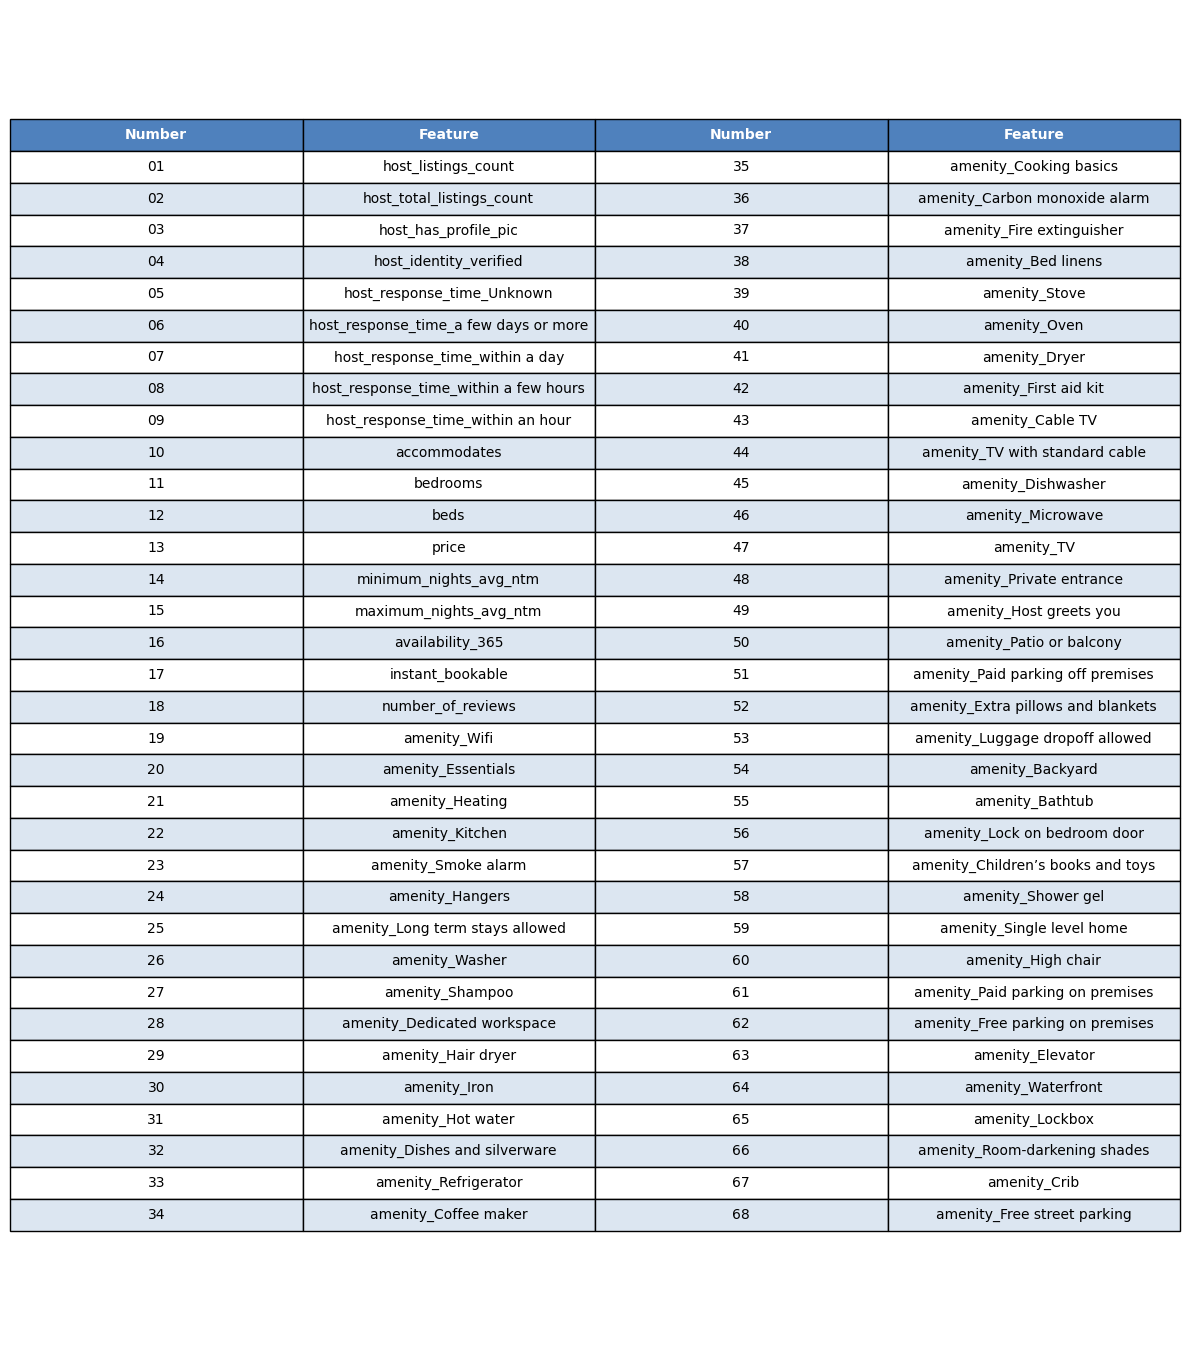

In [59]:
df2 = df_listings_detailed[selected_features] 
# Number of columns in the final table
n_columns = 2
 
# Prepare data
num_features = len(df2.columns)
rows = int(np.ceil(num_features / n_columns))
 
# Split features into columns
feature_chunks = [df2.columns[i*rows:(i+1)*rows] for i in range(n_columns)]
no_chunks = [range(i*rows+1, min((i+1)*rows+1, num_features+1)) for i in range(n_columns)]
 
# Build the cell text for the table
cell_text = []
for i in range(rows):
    row = []
    for col in range(n_columns):
        if i < len(feature_chunks[col]):
            row.extend([f"{no_chunks[col][i]:02d}", feature_chunks[col][i]])
        else:
            row.extend(["", ""])  # empty cells if uneven
    cell_text.append(row)
 
# Build column labels
col_labels = []
for i in range(n_columns):
    col_labels.extend(["Number", "Feature"])
 
# Plot
fig, ax = plt.subplots(figsize=(12, rows*0.4))
ax.axis('off')
 
table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)
 
# Style header and alternating rows
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4F81BD')
    else:
        if i % 2 == 0:
            cell.set_facecolor('#DCE6F1')
        else:
            cell.set_facecolor('white')
 
# Adjust font size
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
 
plt.tight_layout()
plt.savefig("features_table_pretty.png", dpi=300)
plt.show()
 

In [47]:
#Prepare data for modeling
target = 'review_scores_rating'

df = df_listings_detailed[selected_features + [target]].copy()
df.dropna(inplace=True)


X = df[selected_features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Modelling & Evaluation

In [ ]:
# Define models and hyperparameter grids. The grids are not that extensive to save time.
models = {
    'CART': (DecisionTreeRegressor(), {
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': [10, 20, 50]
    }),
    'RandomForest': (RandomForestRegressor(n_jobs=-1), {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8]
    }),
    'GradientBoosting': (GradientBoostingRegressor(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4]
    }),
    'Ridge': (Ridge(), {
        'alpha': [0.1, 1.0, 10.0]
    }),
    'Lasso': (Lasso(max_iter=10000), {
        'alpha': [0.01, 0.1, 1.0]
    }),
    'XGBoost': (xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42), {
        'n_estimators': [200, 500],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1]
    })
}


# Run GridSearchCV for each model and record scores
results = []

for name, (model, param_grid) in models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({
        'Model': name,
        'Best_Params': grid.best_params_,
        'R2': r2,
        'RMSE': rmse
    })

# ----------------------------------------------------
# Save results to DataFrame and sort by R2
# ----------------------------------------------------
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
results_df


Training CART...
Training RandomForest...
Training GradientBoosting...
Training Ridge...
Training Lasso...
Training XGBoost...


,Model,Best_Params,R2,RMSE
5,XGBoost,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.142130,0.199330
2,GradientBoosting,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.140481,0.199521
1,RandomForest,"{'max_depth': 8, 'n_estimators': 200}",0.134749,0.200185
3,Ridge,{'alpha': 10.0},0.115355,0.202416
0,CART,"{'max_depth': 3, 'min_samples_split': 20}",0.089156,0.205392
4,Lasso,{'alpha': 0.01},0.064576,0.208145


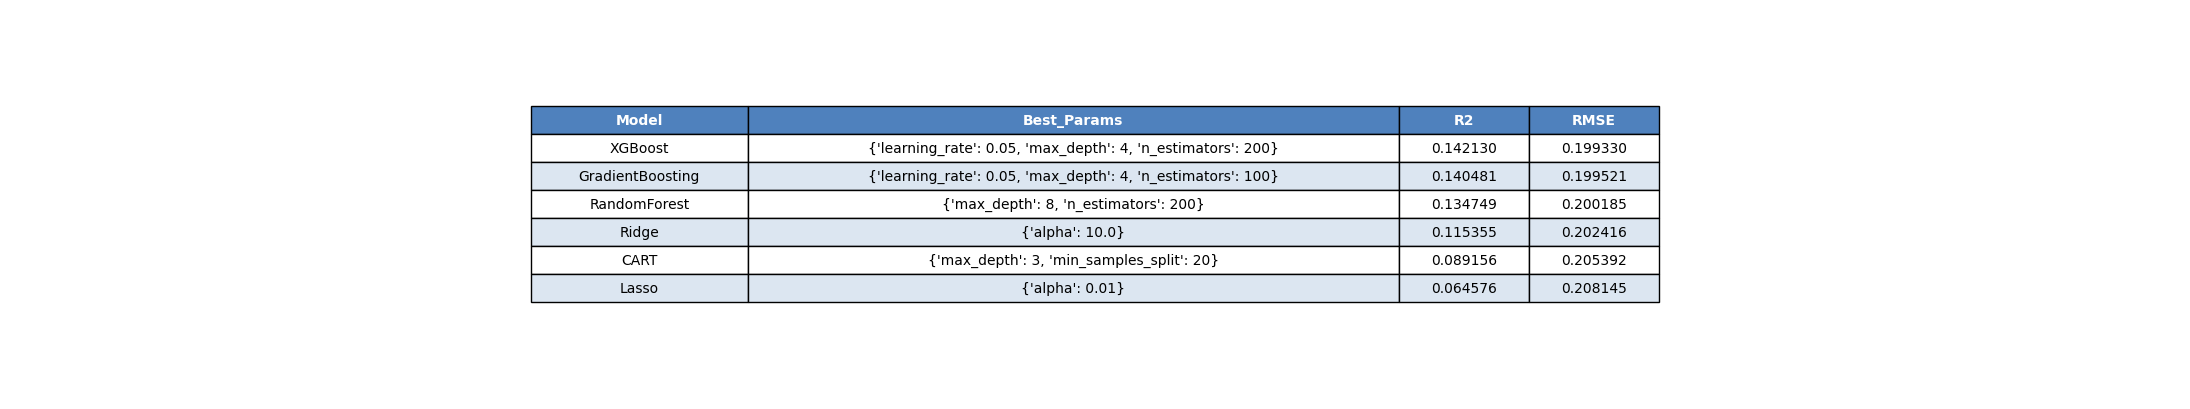

In [70]:

n_columns = 1

num_models = len(results_df)
rows = int(np.ceil(num_models / n_columns))

# Split results_df into chunks
chunks = [
    results_df.iloc[i*rows:(i+1)*rows].reset_index(drop=True)
    for i in range(n_columns)
]

# Construct cell_text
cell_text = []
for i in range(rows):
    row = []
    for block in chunks:
        if i < len(block):
            row.extend([
                block.loc[i, "Model"],
                block.loc[i, "Best_Params"],
                f"{block.loc[i, 'R2']:.6f}",
                f"{block.loc[i, 'RMSE']:.6f}"
            ])
        else:
            row.extend(["", "", "", ""])
    cell_text.append(row)

# Column labels
col_labels_single = ["Model", "Best_Params", "R2", "RMSE"]
col_labels = col_labels_single * n_columns

# ---------------------------------
# Plot
# ---------------------------------
fig, ax = plt.subplots(figsize=(22, rows * 0.7))
ax.axis('off')

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    loc='center',
    cellLoc='center'
)

# Styling
for (i, j), cell in table.get_celld().items():
    if i == 0:  # header
        cell.set_facecolor("#4F81BD")
        cell.set_text_props(color="white", weight="bold")
    else:
        cell.set_facecolor("#DCE6F1" if i % 2 == 0 else "white")

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)

# Column widths
col_widths = {
    0: 0.10,
    1: 0.30,
    2: 0.06,
    3: 0.06
}

for (row, col), cell in table.get_celld().items():
    if col in col_widths:
        cell.set_width(col_widths[col])

plt.tight_layout()
plt.savefig("model_table_from_results_df.png", dpi=300)
plt.show()


                             feature  importance
0                              price    0.135549
1                  number_of_reviews    0.101125
2      amenity_Dishes and silverware    0.064974
3             minimum_nights_avg_ntm    0.058834
4                host_listings_count    0.058779
5          host_total_listings_count    0.055149
6                               beds    0.041168
7                       accommodates    0.030636
8             maximum_nights_avg_ntm    0.026278
9                   availability_365    0.025698
10                    amenity_Washer    0.025087
11                      amenity_Iron    0.023310
12                amenity_Hair dryer    0.022669
13                  instant_bookable    0.022432
14                 amenity_Hot water    0.018751
15                        amenity_TV    0.016419
16                      amenity_Wifi    0.015795
17               amenity_Smoke alarm    0.015220
18       amenity_Free street parking    0.013516
19  amenity_Free par

<Axes: ylabel='feature'>

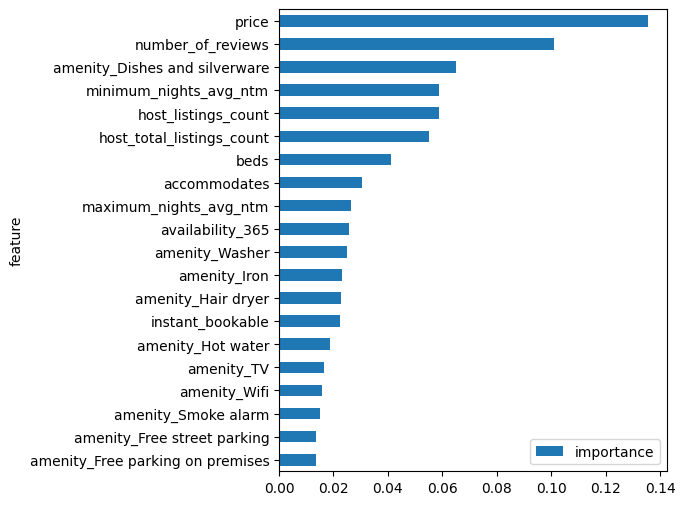

In [ ]:
model = RandomForestRegressor(**results_df.loc[results_df['Model'] == 'RandomForest', 'Best_Params'].values[0])

model.fit(X_train, y_train)

importances = model.feature_importances_
feature_names = X_train.columns

feature_importance_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

feature_importance_df = feature_importance_df[feature_importance_df['importance'] > 0]


print(feature_importance_df.head(20))   # show top 20

feature_importance_df.head(20).sort_values('importance').plot(
        kind='barh',
        x='feature',
        y='importance',
        figsize=(5, 6))


c:\Users\mhoogeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



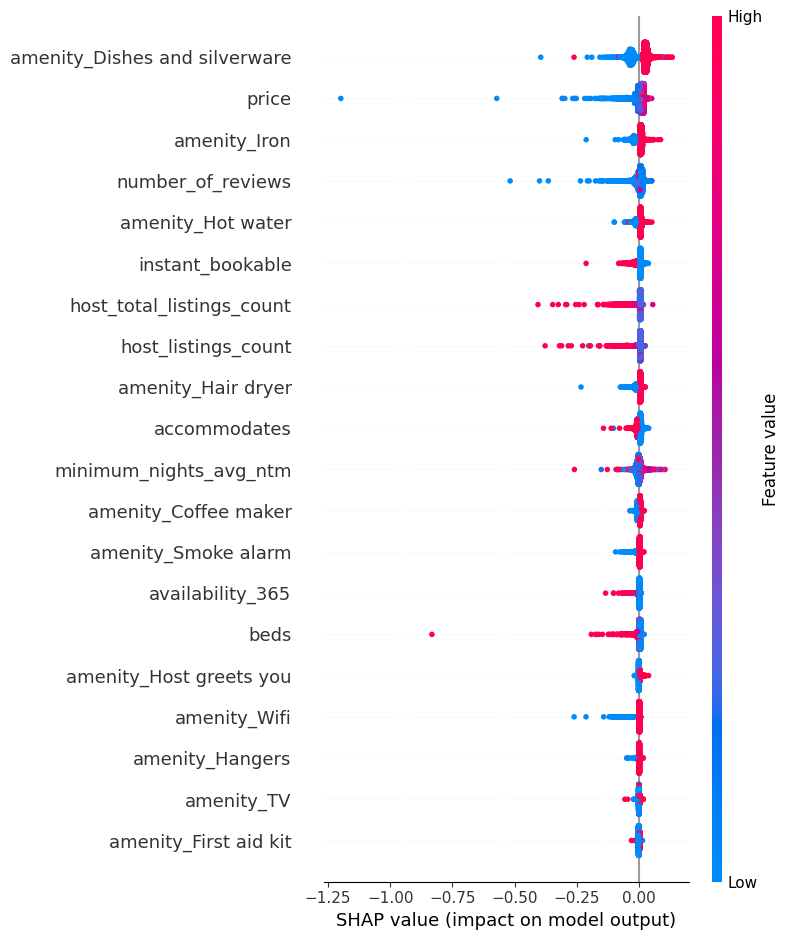

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


# Deployment (LIME)

``the code below generates a Lime table from a random listing.``

In [50]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['review_scores_rating'],
    mode='regression'
)


c:\Users\mhoogeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

c:\Users\mhoogeb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

C:\Users\mhoogeb\AppData\Local\Temp\ipykernel_23092\599042350.py:61: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



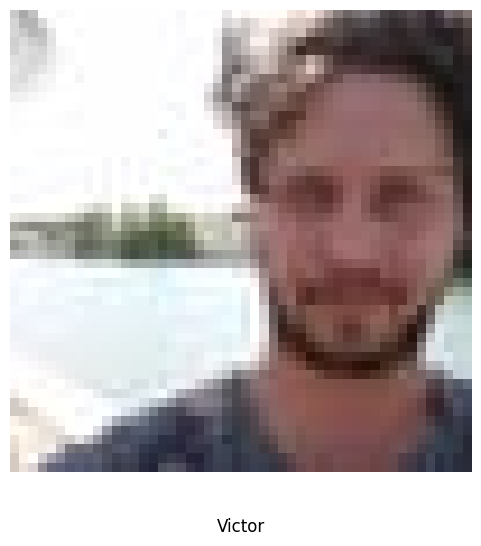

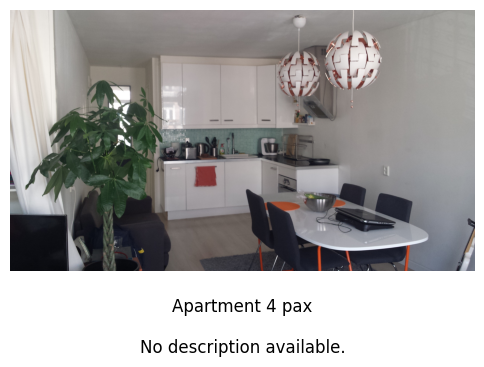

In [54]:
i = random.randint(0, len(X_test) - 1)  # inclusive range
listing_data = df_listings_detailed.loc[X_test.index[i]]
predicted_score = round(model.predict([X_test.iloc[i].values])[0], 2)
actual_review_score = round(np.array(y_test)[i],2)



exp = explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=model.predict,
    num_features=15    # top features to show
)

lime_exp_list = exp.as_list()

# Convert to DataFrame
exp_df = pd.DataFrame(lime_exp_list, columns=['feature', 'contribution'])

exp_df['contribution'] = round(exp_df['contribution'],4)


#Sorting
exp_df['abs_contribution'] = exp_df['contribution'].abs()
exp_df = exp_df.sort_values('abs_contribution', ascending=True)  # for horizontal bar plot


# ----------------------------------------------------
# Extract data
# ----------------------------------------------------
lat = float(listing_data["latitude"])
lon = float(listing_data["longitude"])
listing_title = listing_data.get("name", "No Title")
host_name = listing_data.get("host_name", "Unknown Host")
host_img_url = listing_data.get("host_thumbnail_url", None)
host_description = listing_data.get("host_about", "No description available.")
picture_url = listing_data.get("picture_url", None)  # if you want clickable URLs



# Load host image if available
host_img = None
if host_img_url and isinstance(host_img_url, str) and host_img_url.startswith("http"):
    try:
        response = requests.get(host_img_url)
        host_img = Image.open(BytesIO(response.content))
    except:
        host_img = None

# Load listing image
listing_img = None
if picture_url and isinstance(picture_url, str) and picture_url.startswith("http"):
    try:
        response = requests.get(picture_url)
        listing_img = Image.open(BytesIO(response.content))
    except:
        listing_img = None        

# ----------------------------------------------------
# 1. Map plot using Plotly
# ----------------------------------------------------
map_fig = go.Figure(go.Scattermapbox(
    lat=[lat],
    lon=[lon],
    mode="markers",
    marker=dict(size=14, color="red"),
    text=[listing_title]
))

map_fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        zoom=12,
        center=dict(lat=lat, lon=lon)
    ),
    title_text="Listing Location",
    height=500,
    width=700,
    margin=dict(l=0, r=0, t=0, b=0)
)

map_fig.show()

# ----------------------------------------------------
# 2. Host Info using Matplotlib
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')  # Hide axes

if host_img is not None:
    ax.imshow(host_img)
ax.text(0.5, -0.1, f"{host_name}",
        ha='center', va='top', wrap=True, fontsize=12, transform=ax.transAxes)

plt.show()

# ----------------------------------------------------
# 2. Listing Image
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')  # Hide axes

if listing_img is not None:
    ax.imshow(listing_img)
ax.text(0.5, -0.1, f"{listing_title}\n\n{host_description}",
        ha='center', va='top', wrap=True, fontsize=12, transform=ax.transAxes)

plt.show()


# ----------------------------------------------------
# 3. LIME Feature Contributions (Plotly Bar)
# ----------------------------------------------------
lime_fig = go.Figure(go.Bar(
    x=exp_df['contribution'],
    y=exp_df['feature'],
    orientation='h',
    marker=dict(
        color=exp_df['contribution'],
        colorscale='RdBu',
        cmin=-exp_df['abs_contribution'].max(),
        cmax=exp_df['abs_contribution'].max()
    ),
    text=exp_df['contribution'],
    textposition='auto',
    textfont=dict(size=32)  # Increase font size of bar text

))

lime_fig.update_layout(
    title_text=f"LIME Feature Contributions (Predicted: {predicted_score}, Actual: {actual_review_score})",
    width=900,
    paper_bgcolor='white'
    
)

lime_fig.show()


